# Temporal difference (TD) learning

Temporal difference learning is a model-free reinforcement learning algorithm. 

A `model` in RL is the policy matrix: the probabilities of transitioning from one state to another. 

An agent in the TD learning framework does not have a model of the environment. Instead, it learns the policy matrix by interacting with the environment.

# Definition recap 

Before diving deeper into TD learning, we need to define some additional terms.

`Control` - the process of learning the optimal policy (finding the policy matrix $P$).

`Prediction` - the process of learning the value $v_{\pi} (s)$ and $q_{\pi}(a, s)$ function with a fixed policy $\pi$ for all $s$ and $a$ (finding the value matrix $V$).

`Bootstrapping` - the process of using the current estimate of the value function to estimate the value function for the next state.

`Episode` - the process of interacting with the environment until the episode is terminated (the terminal state is reached).

`Step` - a single interaction with the environment. 

`State` - the current state of the environment.

`Action` - the action taken by the agent.

`Reward` - the reward received by the agent.

`State value` - the total expected accumlated reward if the agent moves from the current state: 

$v_{\pi}(s) = V(s) = \mathbb{E} \left[R_{t +1} + \gamma R_{t + 2} + ... + \gamma ^{K} R_{t+K} \right | s_{t} = s]$

# TD(0) algorithm 

The TD(0) algorithm is a model-free reinforcement learning algorithm. It is a special case of the TD learning algorithm. The basis of it is that the agent chooses an action based on policy $\pi$, observes the reward and the next state, and then updates the value function $v_{\pi}(s)$ for the current state $s$. 

The full algorithm is as follows:
 
1. Initialization:

1.1 Initialize the value function $v_{\pi}(s)$ for all $s$ arbitrarily, except for the terminal state $v_{\pi}(s_{terminal}) = 0$. 

1.1. Define the number of episodes $N$.

1.2. Define the learning rate $\alpha \in (0, 1]$.

1.3. Define the discount factor $\gamma \in [0, 1]$.

2. For each episode n = 1, 2, ..., $N$:

    1. Initialize the state $s$.
    
    2. While the state $s$ is not terminal:
    
        2.1. Choose an action $a$ from the state $s$ using policy $\pi$.
        
        2.2. Observe the reward $r$ and the next state $s'$.
        
        2.3. Update the state value: $v_{\pi}(s) \leftarrow v_{\pi}(s) + \alpha \left[r + \gamma v_{\pi}(s') - v_{\pi}(s)\right]$
            
        2.4. Set $s \leftarrow s'$.

TD algorithm above works particulary well if our agent, at the end of each episode, returns to the initial state and continues the episode from there.

# Initializing the frozen lake environment

We will create an environment where our agent needs go from the initial state to the goal without falling into a random generated set of holes. 

Each step is rewarded with a reward of -1 and the goal state has a reward of 10. If an agent falls into the hole, it receives a reward of -10 and the episode is terminated. If the agent reaches the goal, the episode is also terminated.

In [2]:
# Importing python packages 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns 
from typing import Tuple
import time 

# Rectangle
from matplotlib.patches import Rectangle

# Iteration tracking 
from tqdm import tqdm

In [3]:
def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> Tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

In [4]:
def plot_matrix(
    M: np.array, 
    goal_coords: list = [],
    hole_coords: list = [],
    img_width: int = 5, 
    img_height: int = 5, 
    title: str = None,
    ) -> None: 
    """
    Plots a matrix as an image.
    """
    height, width = M.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    
    for x in range(height):
        for y in range(width):
            # By default, the (0, 0) coordinate in matplotlib is the bottom left corner,
            # so we need to invert the y coordinate to plot the matrix correctly
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)
            
            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray 
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            # If there is a tuple of (x, y) in the hole_coords list, we color the cell salmon
            elif (x, y) in hole_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='salmon'))
            
            ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')

    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.show()

In [5]:
def plot_policy_matrix(P: dict, S:np.array, terminal_coords: list = [], img_width: int = 5, img_height: int = 5, title: str = None) -> None: 
    """ 
    Plots the policy matrix out of the dictionary provided; The dictionary values are used to draw the arrows 
    """
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    for x in range(height):
        for y in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)
            
            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray 
            if (x, y) in terminal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            
            else:
                try:
                    # Adding the arrows to the plot
                    if 'up' in P[S[x, y]]:
                        plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                    if 'down' in P[S[x, y]]:
                        plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                    if 'left' in P[S[x, y]]:
                        plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                    if 'right' in P[S[x, y]]:
                        plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)
                except Exception as e:
                    print(f"Error: {e}")
                    print(f"Current x and y: {x}, {y}")
                    
    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)

In [6]:
def init_policy(S: np.array, weight_dict: dict = {'right': 1}) -> dict:
    # Saving all the unique states to a vector 
    states = np.unique(S)

    # Getting the number of rows and columns of the S matrix
    n_row = S.shape[0]
    n_col = S.shape[1]

    # Dictionary to hold each action for a given state
    P = {}
    for s in states: 
        s_dict = {}

        # Checking which index is the current state in the S matrix 
        s_index = np.where(S == s)

        # If the state is in the top left corner, we can only move right and down
        if s_index == (0, 0):
            s_dict['right'] = 0.5 * weight_dict['right']
            s_dict['down'] = 1 - s_dict['right']
        
        # If the state is in the top right corner, we can only move left and down
        elif s_index == (0, n_col - 1):
            s_dict['left'] = 0.5
            s_dict['down'] = 0.5
        
        # If the state is in the bottom left corner, we can only move right and up
        elif s_index == (n_row - 1, 0):
            s_dict['right'] = 0.5 * weight_dict['right']
            s_dict['up'] = 1 - s_dict['right']
        
        # If the state is in the bottom right corner, we can only move left and up
        elif s_index == (n_row - 1, n_col - 1):
            s_dict['left'] = 0.5
            s_dict['up'] = 0.5
        
        # If the state is in the first row, we can only move left, right, and down
        elif s_index[0] == 0:
            s_dict['right'] = 0.333 * weight_dict['right']
            s_dict['left'] = (1 - s_dict['right']) / 2
            s_dict['down'] =  (1 - s_dict['right']) / 2
        
        # If the state is in the last row, we can only move left, right, and up
        elif s_index[0] == n_row - 1:
            s_dict['right'] = 0.333 * weight_dict['right']
            s_dict['left'] =  (1 - s_dict['right']) / 2
            s_dict['up'] = (1 - s_dict['right']) / 2
        
        # If the state is in the first column, we can only move up, down, and right
        elif s_index[1] == 0:
            s_dict['right'] = 0.333 * weight_dict['right']
            s_dict['up'] = (1 - s_dict['right']) / 2
            s_dict['down'] = (1 - s_dict['right']) / 2
            
        # If the state is in the last column, we can only move up, down, and left
        elif s_index[1] == n_col - 1:
            s_dict['up'] = 0.333
            s_dict['down'] = 0.333
            s_dict['left'] = 1 - s_dict['up'] - s_dict['down']

        # If the state is in the middle, we can move in all directions
        else:
            s_dict['right'] = 0.25 * weight_dict['right']
            s_dict['up'] = (1 - s_dict['right']) / 3
            s_dict['down'] = (1 - s_dict['right']) / 3
            s_dict['left'] = (1 - s_dict['right']) / 3
            
        # Saving the current states trasition probabilities
        P[s] = s_dict

    return P

In [7]:
def generate_holes(nrow: int, ncol: int, start_coords: list, hole_coords: list, nholes: int = 1) -> list:
    """
    Function that generates nholes in a gridworld 

    The holes cannot be: 
        - in the start state
        - in the goal state
    """
    # Generating the hole coordinates 
    # The hole cannot be in the start or goal state
    hole_coords = []
    for _ in range(nholes):

        hole_row = np.random.randint(0, nrow - 1)
        hole_col = np.random.randint(0, ncol - 1)

        while (hole_row, hole_col) in start_coords or (hole_row, hole_col) in hole_coords:
            hole_row = np.random.randint(0, nrow - 1)
            hole_col = np.random.randint(0, ncol - 1)

        # Appending to the hole coordinates list
        hole_coords.append((hole_row, hole_col))

    return hole_coords

def init_env(
        n_rows: int, 
        n_cols: int,
        step_reward: float = -1, 
        goal_reward: float = 10,
        hole_reward: float = -10,
        n_holes: int = 1,
        random_seed: int = 42, 
        policy_weights: dict = {'right': 1}
        ) -> np.array: 
    """
    Functionat that returns the initial environment: 
        S - the state matrix indexed by [row, col]
        V - the initial value matrix indexed by [row, col]
        R - the reward matrix indexed by [row, col]
        A - the action matrix indexed by [row, col]
        P - the probability dictionary where for each state, the keys are the actions and the values are the probabilities of the next state
    """
    # Setting the random seed
    np.random.seed(random_seed)
    
    # Initiating the S matrix 
    S = np.arange(0, n_rows * n_cols).reshape(n_rows, n_cols)

    # Creating the initial V matrix
    V = np.zeros((n_rows, n_cols))

    # The start state will be always the top left corner 
    # The goal state will be always the bottom right corner
    # We will generate a random holes that our agent can fall in
    # Any other state that is not the hole or the goal state will receive a step reward 
    goal_coord = (n_rows - 1, n_cols - 1)
    R = np.zeros((n_rows, n_cols))
    R.fill(step_reward)
    R[0, 0] = step_reward
    R[goal_coord] = goal_reward

    # Generating the hole coordinates 
    # The hole cannot be in the start or goal state
    hole_coords = generate_holes(n_rows, n_cols, [(0, 0)], [goal_coord], n_holes)

    # Setting the hole reward
    for hole_coord in hole_coords:
        R[hole_coord] = hole_reward
        
    # Initiating the policy 
    P = init_policy(S, weight_dict=policy_weights)

    return S, V, R, P, hole_coords, [goal_coord]

# Defining the agent exploration abilities 

In [8]:
def select_move(s, S, P) -> int:
    """
    Given the current state, returns the coordinates of the next state based on the current policy 
    """
    # Getting the current state index 
    s_index = np.where(S == s)

    # Getting the current state policy
    s_policy = P[s]

    # Selecting the next action based on the current policy
    next_action = np.random.choice(list(s_policy.keys()), p=list(s_policy.values()))

    # Getting the next state coordinates based on the next action
    try:
        if next_action == 'up':
            next_state = S[s_index[0] - 1, s_index[1]][0]
        elif next_action == 'down':
            next_state = S[s_index[0] + 1, s_index[1]][0]
        elif next_action == 'left':
            next_state = S[s_index[0], s_index[1] - 1][0]
        elif next_action == 'right':
            next_state = S[s_index[0], s_index[1] + 1][0]
    except Exception as e: 
        print(f"Current state: {s}")
        print(f'Next action: {next_action}')
        print(f'Error: {e}')

    return next_state

def get_state_coords(s, S) -> tuple:
    """
    Returns the state coordinates given the state index
    """
    s_index = np.where(S == s)
    return s_index[0][0], s_index[1][0]

def update_value(s, s_prime, S, P, V, R, alpha: float = 0.1, gamma: float = 0.9) -> float: 
    """
    Updates the current value function based on the current policy
    """
    # Getting the CURRENT state's nrow and ncol index
    s_index_now = get_state_coords(s, S)

    # Getting the SELECTED state's nrow and ncol index
    s_index_prime = get_state_coords(s_prime, S)

    # Getting the reward by moving to the selected state 
    move_reward = R[s_index_prime[0], s_index_prime[1]]

    # Getting the current estimated value of the selected state 
    current_value = V[s_index_now[0], s_index_now[1]]

    # The next value 
    prime_value = V[s_index_prime[0], s_index_prime[1]]

    # Returning the TD(0) current state value 
    return current_value + alpha * (move_reward + gamma * prime_value - current_value)

def episode_exploration(S, P, V, R, terminal_state_coords: list, alpha: float = 0.1, gamma: float = 0.9) -> None: 
    """
    Agent exploration and value updating using TD(0) equation until a terminal state is reached
    """
    # The starting state is 0 
    s = 0 

    # Keeping track of the number of moves
    n_moves = 0

    # Getting the coordinates of the s 
    s_coords = get_state_coords(s, S)

    while s_coords not in terminal_state_coords:
        # Selecting the next state based on the current policy
        s_prime = select_move(s, S, P)

        # Updating the current state value 
        V[s_coords] = update_value(s, s_prime, S, P, V, R, alpha, gamma)

        # Updating the current state 
        s = s_prime

        # Incrementing the number of moves
        n_moves += 1

        # Getting teh new s coords
        s_coords = get_state_coords(s, S)
    
    return n_moves


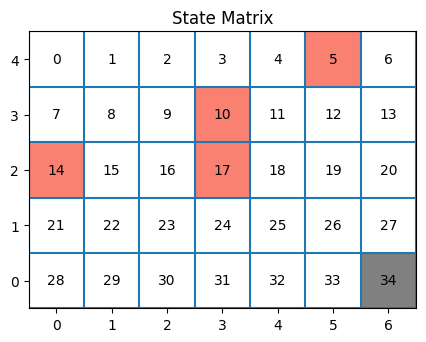

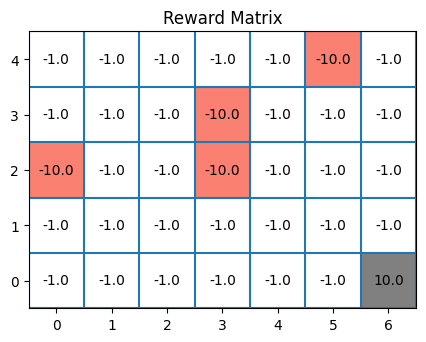

In [9]:
S, V, R, P, hole_coords, goal_coard = init_env(5, 7, n_holes=4, random_seed=3)
plot_matrix(S, goal_coords=goal_coard, hole_coords=hole_coords, title='State Matrix')
plot_matrix(R, goal_coords=goal_coard, hole_coords=hole_coords, title='Reward Matrix')

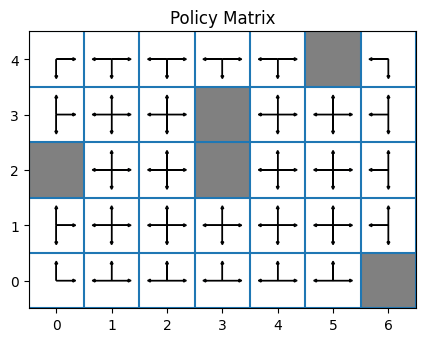

In [10]:
plot_policy_matrix(P, S, terminal_coords=hole_coords + goal_coard, title='Policy Matrix')

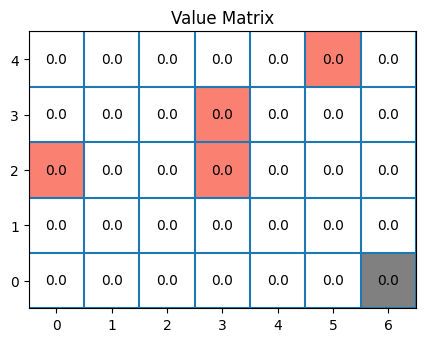

In [11]:
plot_matrix(V, goal_coords=goal_coard, hole_coords=hole_coords, title='Value Matrix')

In [12]:
P[1]

{'right': 0.333, 'left': 0.3335, 'down': 0.3335}

In [13]:
# Defining the number of episodes to explore 
n_episodes = 10000

# We will plot the V matrix after each episode filling the same device plot to make an animation
number_of_walks = []
for _ in tqdm(range(n_episodes)):
    n = episode_exploration(S, P, V, R, terminal_state_coords=hole_coords + goal_coard, alpha=0.1, gamma=0.9)
    number_of_walks.append(n)

100%|██████████| 10000/10000 [00:07<00:00, 1316.57it/s]


In [14]:
sum_V = V.sum()
print(f'The sum of the V matrix is: {sum_V:.2f}')

The sum of the V matrix is: -249.29


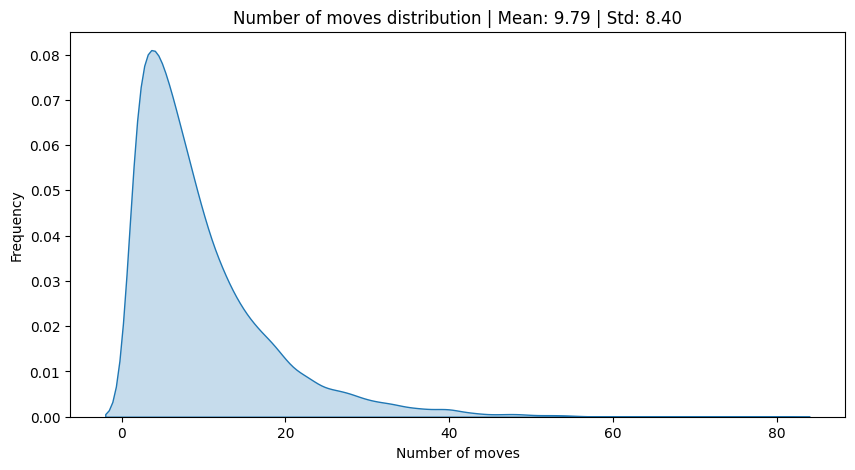

In [15]:
# Ploting the distribution of the number of moves 
plt.figure(figsize=(10, 5))
sns.kdeplot(number_of_walks, fill=True)
plt.title(f'Number of moves distribution | Mean: {np.mean(number_of_walks):.2f} | Std: {np.std(number_of_walks):.2f}')
plt.xlabel('Number of moves')
plt.ylabel('Frequency')
plt.show()

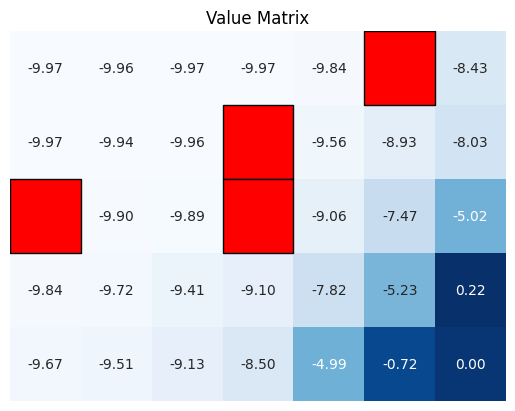

In [16]:
# Hardcoding np nan to the hole and goal states
for hole_coord in hole_coords:
    V[hole_coord] = np.nan

# Plotting the V matrix
sns.heatmap(V, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=False, yticklabels=False)

# Adding a black border around the hole_coords
for hole_coord in hole_coords:
    plt.gca().add_patch(Rectangle((hole_coord[1], hole_coord[0]), 1, 1, fill=True, edgecolor='black', lw=1, facecolor='red'))
plt.title('Value Matrix')
plt.show()

In [17]:
# Assiging a different policy
S, V, R, P, hole_coords, goal_coard = init_env(5, 7, n_holes=4, random_seed=3, policy_weights={'right': 1.5}) 

In [18]:
# Defining the number of episodes to explore 
n_episodes = 10000

# We will plot the V matrix after each episode filling the same device plot to make an animation
number_of_walks = []
for _ in tqdm(range(n_episodes)):
    n = episode_exploration(S, P, V, R, terminal_state_coords=hole_coords + goal_coard, alpha=0.1, gamma=0.9)
    number_of_walks.append(n)

100%|██████████| 10000/10000 [00:07<00:00, 1304.46it/s]


In [19]:
sum_V = V.sum()
print(f'The sum of the V matrix is: {sum_V:.2f}')

The sum of the V matrix is: -213.51


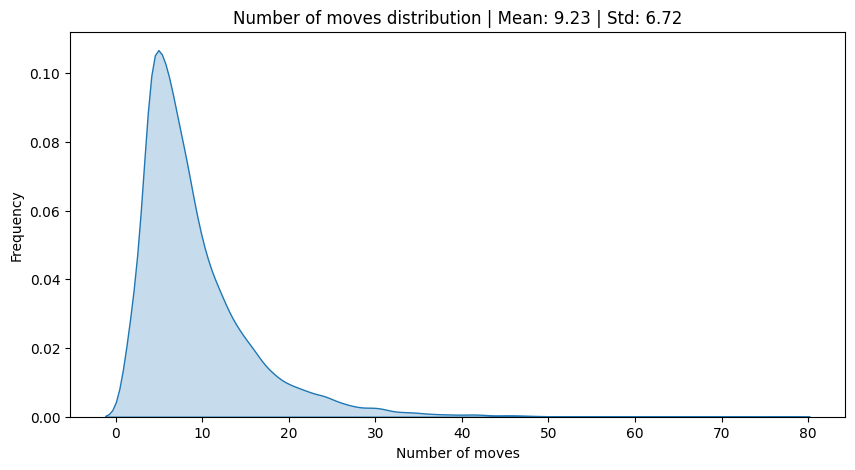

In [20]:
# Ploting the distribution of the number of moves 
plt.figure(figsize=(10, 5))
sns.kdeplot(number_of_walks, fill=True)
plt.title(f'Number of moves distribution | Mean: {np.mean(number_of_walks):.2f} | Std: {np.std(number_of_walks):.2f}')
plt.xlabel('Number of moves')
plt.ylabel('Frequency')
plt.show()

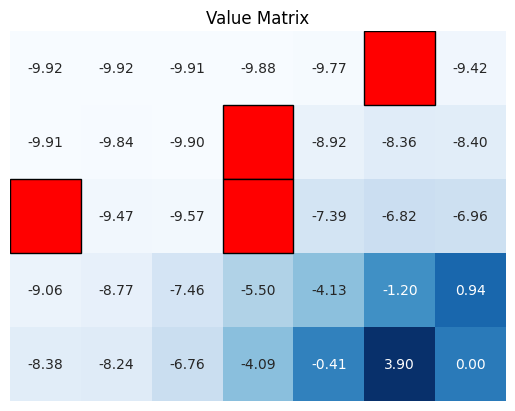

In [21]:
# Hardcoding np nan to the hole and goal states
for hole_coord in hole_coords:
    V[hole_coord] = np.nan

# Plotting the V matrix
sns.heatmap(V, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=False, yticklabels=False)

# Adding a black border around the hole_coords
for hole_coord in hole_coords:
    plt.gca().add_patch(Rectangle((hole_coord[1], hole_coord[0]), 1, 1, fill=True, edgecolor='black', lw=1, facecolor='red'))
plt.title('Value Matrix')
plt.show()